# Building a RAG application with LangChain and AWS Sagemaker
From https://github.com/generative-ai-on-aws/generative-ai-on-aws/blob/main/09_rag/01_langchain_llama2_sagemaker.ipynb



# Development environment

In [ ]:
! pip install pypdf

In [ ]:
import langchain
import faiss
import pypdf

# Download PDF documents
The RAG application should be able to answer questions based on ingested documents. In this example, we will download a couple of PDF files containing the Letter to Shareholders by the CEO of Amazon. 

As a tradition, the letter always contains a copy of the first letter to shareholders from 1997. To avoid duplicate information, we remove these pages.

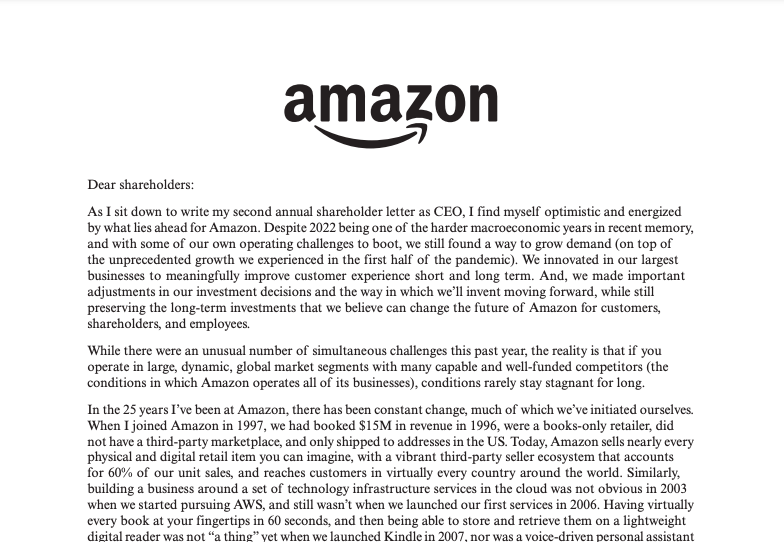

In [ ]:
# fetching data
!mkdir -p ./data

from urllib.request import urlretrieve
urls = [
    'https://s2.q4cdn.com/299287126/files/doc_financials/2023/ar/2022-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2022/ar/2021-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2021/ar/Amazon-2020-Shareholder-Letter-and-1997-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2020/ar/2019-Shareholder-Letter.pdf'
]

filenames = [
    'AMZN-2022-Shareholder-Letter.pdf',
    'AMZN-2021-Shareholder-Letter.pdf',
    'AMZN-2020-Shareholder-Letter.pdf',
    'AMZN-2019-Shareholder-Letter.pdf'
]

metadata = [
    dict(year=2022, source=filenames[0]),
    dict(year=2021, source=filenames[1]),
    dict(year=2020, source=filenames[2]),
    dict(year=2019, source=filenames[3])]

data_root = "./data/"

for idx, url in enumerate(urls):
    file_path = data_root + filenames[idx]
    urlretrieve(url, file_path)

In [ ]:
# remove last pages which are original 1997 letter to shareholder
from pypdf import PdfReader, PdfWriter
import glob

local_pdfs = glob.glob(data_root + '*.pdf')

for local_pdf in local_pdfs:
    pdf_reader = PdfReader(local_pdf)
    pdf_writer = PdfWriter()
    for pagenum in range(len(pdf_reader.pages)-3):
        page = pdf_reader.pages[pagenum]
        pdf_writer.add_page(page)

    with open(local_pdf, 'wb') as new_file:
        new_file.seek(0)
        pdf_writer.write(new_file)
        new_file.truncate()

# Split documents
We first convert the PDF documents into text using PyPDF. Then we use LangChain to automatically split the documents into smaller text chunks of 512 characters. We use an overlap of 100 characters between chunks to make sure we do not lose relevant context. 

In [ ]:
import numpy as np
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader

documents = []

for idx, file in enumerate(filenames):
    loader = PyPDFLoader(data_root + file)
    document = loader.load()
    for document_fragment in document:
        document_fragment.metadata = metadata[idx]
        
    documents += document

# - in our testing Character split works better with this PDF data set
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 100,
)

docs = text_splitter.split_documents(documents)

print(f'# of Document Pages {len(documents)}')
print(f'# of Document Chunks: {len(docs)}')

# Load text embedding model
A text embedding model converts (text) input into a vector representation, similar to Word2Vec. We are using a Hugging Face embedding model and load it via Sagemaker Jumpstart.

Sagemaker Jumpstart provides a model hub where you can quickly provision foundation models for experimentation and fine tuning, as well as pre-build solutions. It is similar to Bedrock but you have more control over the models and need to deploy model endpoints yourself. 


In [ ]:
from sagemaker.jumpstart.model import JumpStartModel

# default instance is ml.g5.2xlarge
embedding_model_id, embedding_model_version = "huggingface-textembedding-all-MiniLM-L6-v2", "*"
model = JumpStartModel(model_id=embedding_model_id, model_version=embedding_model_version)

embedding_predictor = model.deploy()

In [ ]:
#this is the model endpoint NAME, not the ARN
embedding_model_endpoint_name = embedding_predictor.endpoint_name
embedding_model_endpoint_name

In [ ]:
import boto3
aws_region = boto3.Session().region_name

# Compute text embeddings
Compute embeddings for chunks by calling the embedding endpoint. Put document chunks and embeddings into a vector store for fast lookup.  


In [ ]:
from typing import Dict, List
from langchain.embeddings import SagemakerEndpointEmbeddings
from langchain.embeddings.sagemaker_endpoint import EmbeddingsContentHandler
import json


class CustomEmbeddingsContentHandler(EmbeddingsContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, inputs: list[str], model_kwargs: Dict) -> bytes:
        input_str = json.dumps({"text_inputs": inputs, **model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> List[List[float]]:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json["embedding"]


embeddings_content_handler = CustomEmbeddingsContentHandler()


embeddings = SagemakerEndpointEmbeddings(
    endpoint_name=embedding_model_endpoint_name,
    region_name=aws_region,
    content_handler=embeddings_content_handler,
)

In [ ]:
from langchain.schema import Document
from langchain.vectorstores import FAISS

db = FAISS.from_documents(docs, embeddings)

# Query vector store
Let's query the vector store and find relevant chunks for a sample question. We can also filter the search results based on the documents' meta data. 

In [ ]:
query = "How has AWS evolved?"


In [ ]:
results_with_scores = db.similarity_search_with_score(query)
for doc, score in results_with_scores:
    print(f"Content: {doc.page_content}\nMetadata: {doc.metadata}\nScore: {score}\n\n")


In [ ]:
# provide filter to search
filter={"year": 2022}

results_with_scores = db.similarity_search_with_score(query,
  filter=filter)

for doc, score in results_with_scores:
    print(f"Content: {doc.page_content}\nMetadata: {doc.metadata}\nScore: {score}\n\n")

# Prepare prompt template and deploy LLM endpoint for generation

To generate the final answer based on the returned document context, we need an LLM model and a prompt template which puts the question and context together with some instruction. 

In [ ]:
from langchain.prompts import PromptTemplate

prompt_template = """
<s>[INST] <<SYS>>
Use the context provided to answer the question at the end. If you dont know the answer just say that you don't know, don't try to make up an answer.
<</SYS>>

Context:
----------------
{context}
----------------

Question: {question} [/INST]
"""

PROMPT = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"]
)

In [ ]:
from typing import Dict

from langchain import PromptTemplate, SagemakerEndpoint
from langchain.llms.sagemaker_endpoint import LLMContentHandler
from langchain.chains.question_answering import load_qa_chain
from langchain.chains import RetrievalQA
import json


class QAContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs: dict) -> bytes:
        input_str = json.dumps(
            {"inputs" : [
                [
                    {
                        "role" : "system",
                        "content" : ""
                    },
                    {
                        "role" : "user",
                        "content" : prompt
                    }
                ]],
                "parameters" : {**model_kwargs}
            })
        return input_str.encode('utf-8')
    
    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json[0]["generation"]["content"]

qa_content_handler = QAContentHandler()

In [ ]:
# default instance is ml.g5.2xlarge
llm_model_id, llm_model_version = "meta-textgeneration-llama-2-7b-f", "2.*"
llm_model = JumpStartModel(model_id=llm_model_id, model_version=llm_model_version)
llm_predictor = llm_model.deploy()

In [ ]:
#this is the model endpoint NAME, not the ARN
llm_model_endpoint_name = llm_predictor.endpoint_name
llm_model_endpoint_name


In [ ]:
llm = SagemakerEndpoint(
        endpoint_name=llm_model_endpoint_name,
        region_name=aws_region,
        model_kwargs={"max_new_tokens": 1000, "top_p": 0.9, "temperature": 1e-11},
        endpoint_kwargs={"CustomAttributes": 'accept_eula=true'},
        content_handler=qa_content_handler
    )

# Query the RAG application

In [ ]:
query = "How has AWS evolved?"
llm.predict(query)

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    chain_type='stuff',
    retriever=db.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": PROMPT}
)

In [ ]:
query = "How has AWS evolved?"
result = qa_chain({"query": query})
print(f'Query: {result["query"]}\n')
print(f'Result: {result["result"]}\n')
print(f'Context Documents: ')
for srcdoc in result["source_documents"]:
      print(f'{srcdoc}\n')

In [ ]:
query = "Why is Amazon successful?"
result = qa_chain({"query": query})
print(f'Query: {result["query"]}\n')
print(f'Result: {result["result"]}\n')
print(f'Context Documents: ')
for srcdoc in result["source_documents"]:
      print(f'{srcdoc}\n')

In [ ]:
query = "What business challenges has Amazon experienced?"
result = qa_chain({"query": query})
print(f'Query: {result["query"]}\n')
print(f'Result: {result["result"]}\n')
print(f'Context Documents: ')
for srcdoc in result["source_documents"]:
      print(f'{srcdoc}\n')

# Cleanup
Delete the embedding and LLM model endpoints

In [ ]:
# clean up
sagemaker_client = boto3.client('sagemaker', region_name=aws_region)

#Delete embedding endpoint
sagemaker_client.delete_endpoint(EndpointName=embedding_model_endpoint_name)

#Delete llm endpoint
sagemaker_client.delete_endpoint(EndpointName=llm_model_endpoint_name)